# Gradient Boosted Classifier attempt to Titanic Kaggle competition.
As a first model we try the Gradient Boosted Classifier.

The study roadmap:

1. Get data and visualise it
* Train basic version of xgboost classifier
* Tune model hyperparameters
* Perform features engineering  

In [1]:
print("Kernel is alive")

Kernel is alive


In [2]:
# all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures

import xgboost as xgb


import csv as csv
import math

import itertools

# Get training and test data

In [3]:
train_df = pd.read_csv('../datasets/train.csv', header=0)        # Load the train file into a dataframe
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [4]:
test_df = pd.read_csv('../datasets/test.csv', header=0)        # Load the train file into a dataframe
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#find all titles
name_list = train_df.Name.values
title_dict = {}
for name in name_list:
    start = int(name.find(","))+2
    end = int (name.find("."))
    title = name[start:end]
    title_dict[title]=0
titles =title_dict.keys()
print (titles)

['Sir', 'Major', 'the Countess', 'Don', 'Mlle', 'Capt', 'Dr', 'Lady', 'Rev', 'Mrs', 'Jonkheer', 'Master', 'Ms', 'Mr', 'Mme', 'Miss', 'Col']


In [6]:
titles_dictionary={}
for title in titles:
    ages = train_df[train_df.Name.str.contains(title)].Age
    print(title + " count "+str(ages.count()) + " age "+str(ages.mean())+"+/- "+str(ages.std()) + ",max="+str(ages.max())+" ,min = "+str(ages.min()))
    age_mean = ages.mean()
    age_std = ages.std()
    if age_std == 0.0 or np.isnan(age_std):
        age_std = 1
    titles_dictionary[title]= (age_mean,age_std )
    
    

Sir count 2 age 35.5+/- 19.091883092,max=49.0 ,min = 22.0
Major count 2 age 48.5+/- 4.94974746831,max=52.0 ,min = 45.0
the Countess count 1 age 33.0+/- nan,max=33.0 ,min = 33.0
Don count 2 age 45.0+/- 7.07106781187,max=50.0 ,min = 40.0
Mlle count 2 age 24.0+/- 0.0,max=24.0 ,min = 24.0
Capt count 1 age 70.0+/- nan,max=70.0 ,min = 70.0
Dr count 9 age 39.4444444444+/- 10.2726714042,max=54.0 ,min = 23.0
Lady count 1 age 48.0+/- nan,max=48.0 ,min = 48.0
Rev count 6 age 43.1666666667+/- 13.136463248,max=57.0 ,min = 27.0
Mrs count 112 age 35.6428571429+/- 11.5062514484,max=63.0 ,min = 14.0
Jonkheer count 1 age 38.0+/- nan,max=38.0 ,min = 38.0
Master count 36 age 4.57416666667+/- 3.61987164334,max=12.0 ,min = 0.42
Ms count 1 age 28.0+/- nan,max=28.0 ,min = 28.0
Mr count 511 age 33.1183953033+/- 12.5250014351,max=80.0 ,min = 11.0
Mme count 1 age 24.0+/- nan,max=24.0 ,min = 24.0
Miss count 146 age 21.7739726027+/- 12.9902924222,max=63.0 ,min = 0.75
Col count 10 age 35.0+/- 15.5563491861,max=60.0

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


## So now we clearly see that data is very dirty. We need to clean it a little bit. 
The next step is based on script myfirstforest.py

In [8]:
ports_names = list(enumerate(np.unique(train_df['Embarked'])))    # determine all values of Embarked,

In [9]:

def clean_data(dataframe):
    dataframe['Gender'] = dataframe['Sex'].map( {'female': 1, 'male': 2} ).astype(int)
    
    if len(dataframe.Embarked[ dataframe.Embarked.isnull() ]) > 0:
        dataframe.Embarked[ dataframe.Embarked.isnull() ] = dataframe.Embarked.dropna().mode().values

    Ports_dict = { name : i for i, name in ports_names }              # set up a dictionary in the form  Ports : index
    dataframe.Embarked = dataframe.Embarked.map( lambda x: Ports_dict[x]).astype(int)     # Convert all Embark strings to int
    # All the ages with no data -> make the median of all Ages
    for title in titles:
        nb_sample= dataframe.loc[dataframe.Name.str.contains(title) & dataframe.Age.isnull() ].count()[0]
        title_age_mean= titles_dictionary[title][0]
        title_age_std = titles_dictionary[title][1]
        radnoms = np.random.normal(title_age_mean,title_age_std , nb_sample)
        dataframe["Age"][dataframe.Name.str.contains(title) & dataframe.Age.isnull()]=radnoms
    dataframe['Age'] = dataframe['Age'].astype(int)


    # All the missing Fares -> assume median of their respective class
    if len(dataframe.Fare[ dataframe.Fare.isnull() ]) > 0:
        median_fare = np.zeros(3)
        for f in range(0,3):                                              # loop 0 to 2
            median_fare[f] = dataframe[ dataframe.Pclass == f+1 ]['Fare'].dropna().median()
        for f in range(0,3):                                              # loop 0 to 2
            dataframe.loc[ (dataframe.Fare.isnull()) & (dataframe.Pclass == f+1 ), 'Fare'] = median_fare[f]


In [10]:
clean_data(train_df)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,3,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,3,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,3,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,3,2


In [11]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,30.231201,0.523008,0.381594,32.204208,2.536476,1.647587
std,257.353842,0.486592,0.836071,14.300561,1.102743,0.806057,49.693429,0.791503,0.477990
min,1.000000,0.000000,1.000000,-4.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,2.000000,1.000000
50%,446.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,3.000000,2.000000
75%,668.500000,1.000000,3.000000,39.000000,1.000000,0.000000,31.000000,3.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,3.000000,2.000000


In [12]:
clean_data(test_df)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,2,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,3,1
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,NaN,2,2
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,NaN,3,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,NaN,3,1


In [13]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return "other"

# Get all the titles and print how often each one occurs.
train_titles = train_df["Name"].apply(get_title)
test_titles = test_df["Name"].apply(get_title)

print(pd.value_counts(train_titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, 
                 "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8,
                 "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, 
                 "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 9, "other": 11}

for k,v in title_mapping.items():
    train_titles[train_titles == k] = v
    test_titles[test_titles == k] = v

# Add in the title column.
train_df["Title"] = train_titles
test_df['Title'] = test_titles
test_df['Title']=test_df['Title'].astype(int)


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
dtype: int64


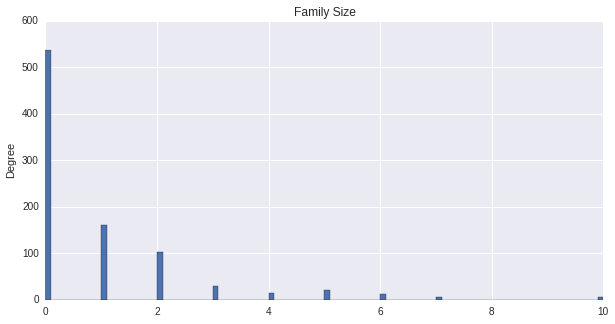

In [14]:
# Family is made up of:
# sibsp = Number of Siblings/Spouses Aboard
# parch = Number of Parents/Children Aboard

train_df['Family'] = train_df['SibSp'] + train_df['Parch']

# visualize family size distribuition
train_df['Family'].plot(kind='hist', title='Family Size', figsize=(10,5),bins=100, xlim=(0,10))

train_df['Family'].loc[train_df['Family'] > 0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# Sibling
train_df['Sibling'] = train_df['SibSp']
train_df['Sibling'].loc[train_df['Sibling'] > 0] = 1
train_df['Sibling'].loc[train_df['Sibling'] == 0] = 0

test_df['Sibling'] = test_df['SibSp']
test_df['Sibling'].loc[test_df['Sibling'] > 0] = 1
test_df['Sibling'].loc[test_df['Sibling'] == 0] = 0

# Parent
train_df['Parent'] = train_df['Parch']
train_df['Parent'].loc[train_df['Parent'] > 0] = 1
train_df['Parent'].loc[train_df['Parent'] == 0] = 0

test_df['Parent'] = test_df['Parch']
test_df['Parent'].loc[test_df['Parent'] > 0] = 1
test_df['Parent'].loc[test_df['Parent'] == 0] = 0

# drop Parch & SibSp from dataframes
train_df = train_df.drop(['SibSp','Parch'], axis=1)
test_df = test_df.drop(['SibSp','Parch'], axis=1)

## Remove useless columns. 
In the further studies we can use Cabin or ticket infor but it is quite tricky. 

In [15]:
target = train_df.Survived
features = train_df.drop(["Survived",'Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1).astype(np.float64)
features.head()

,Pclass,Age,Fare,Embarked,Gender,Title,Family,Sibling,Parent
0,3,22,7.2500,3,2,1,1,1,0
1,1,38,71.2833,1,1,3,1,1,0
2,3,26,7.9250,3,1,2,0,0,0
3,1,35,53.1000,3,1,3,1,1,0
4,3,35,8.0500,3,2,1,0,0,0


### Prepare test dataframe 

In [16]:
ids = test_df['PassengerId'].values
test_features = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 
test_features.head()

,Pclass,Age,Fare,Embarked,Gender,Title,Family,Sibling,Parent
0,3,34,7.8292,2,2,1,0,0,0
1,3,47,7.0000,3,1,3,1,1,0
2,2,62,9.6875,2,2,1,0,0,0
3,3,27,8.6625,3,2,1,0,0,0
4,3,22,12.2875,3,1,3,1,1,1


# Data visualization
Now I made a couple of plots that show us the data structures

In [17]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(10,  20))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2 + 1, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='death', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='alive', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

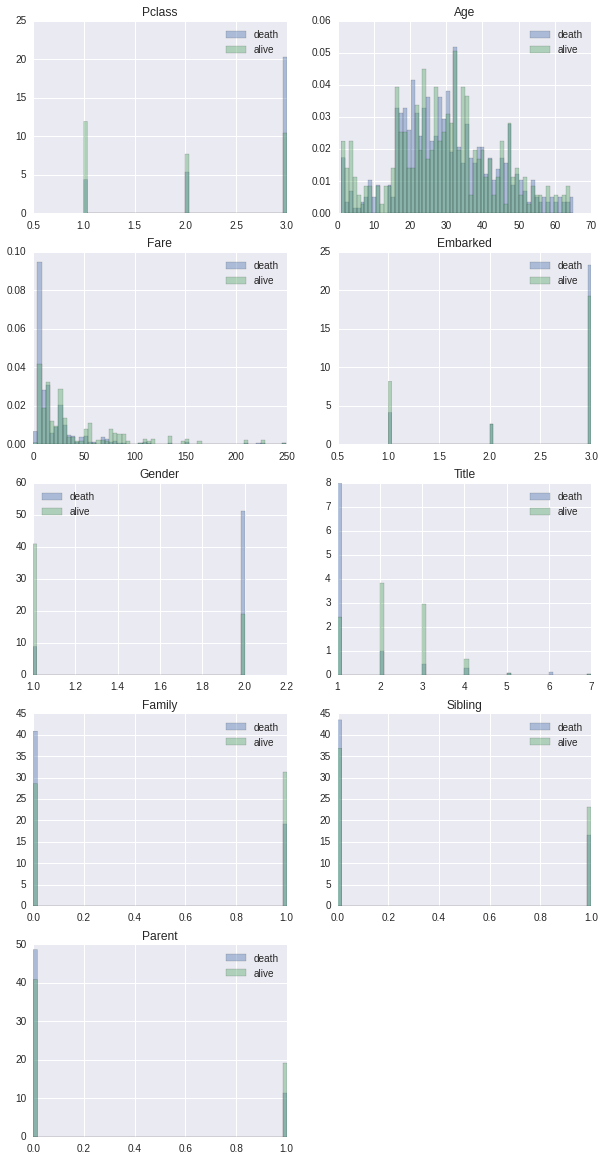

In [18]:
print_features_histograms(features, target)

In [88]:
def pairplot(data, vars):
    sns.pairplot(data, hue="Survived", vars=vars, size=5,palette="husl" ,plot_kws={'alpha': 0.2})


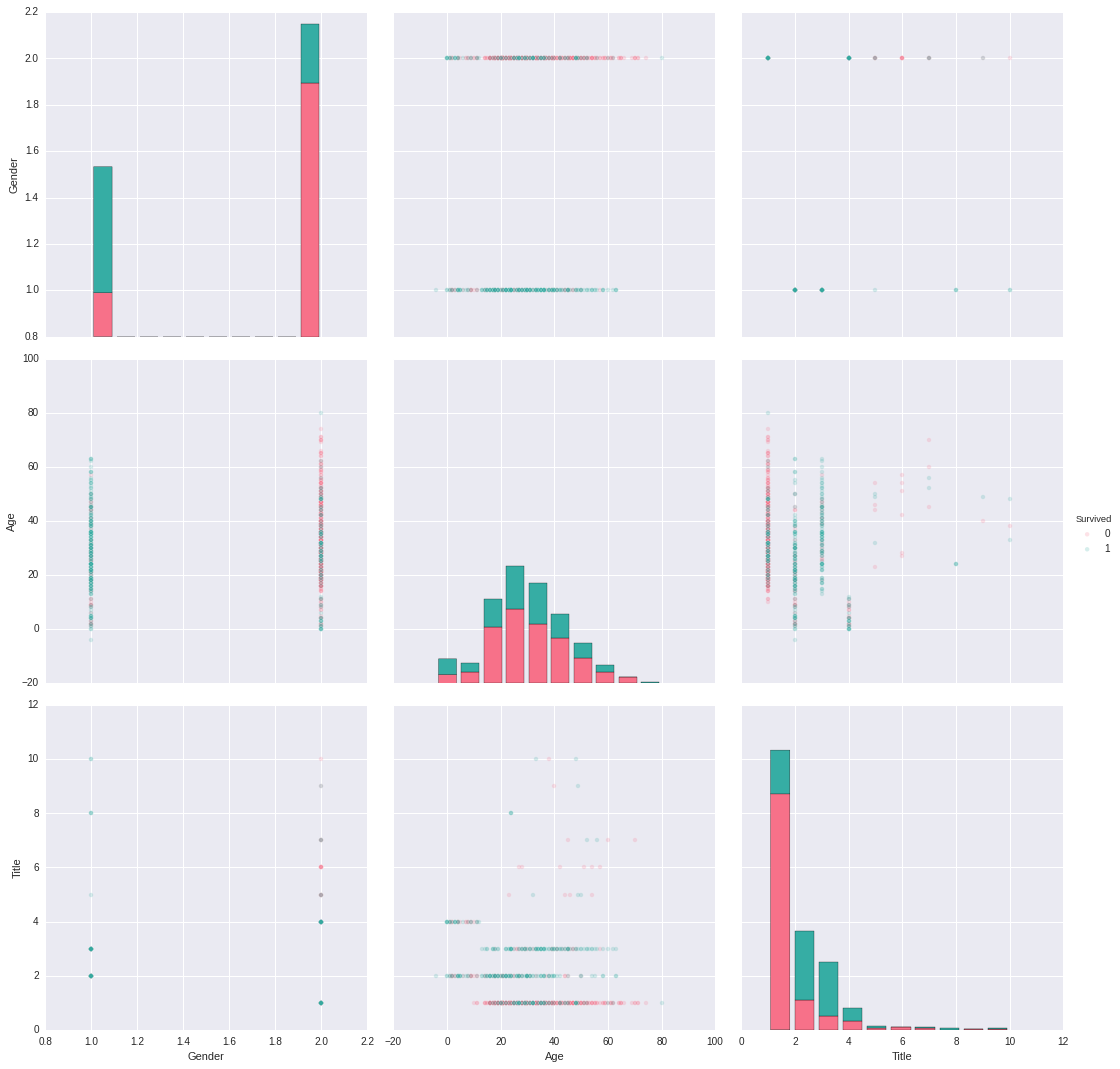

In [89]:
pairplot(train_df,vars=["Gender","Age","Title"])

## show the correlation matrix

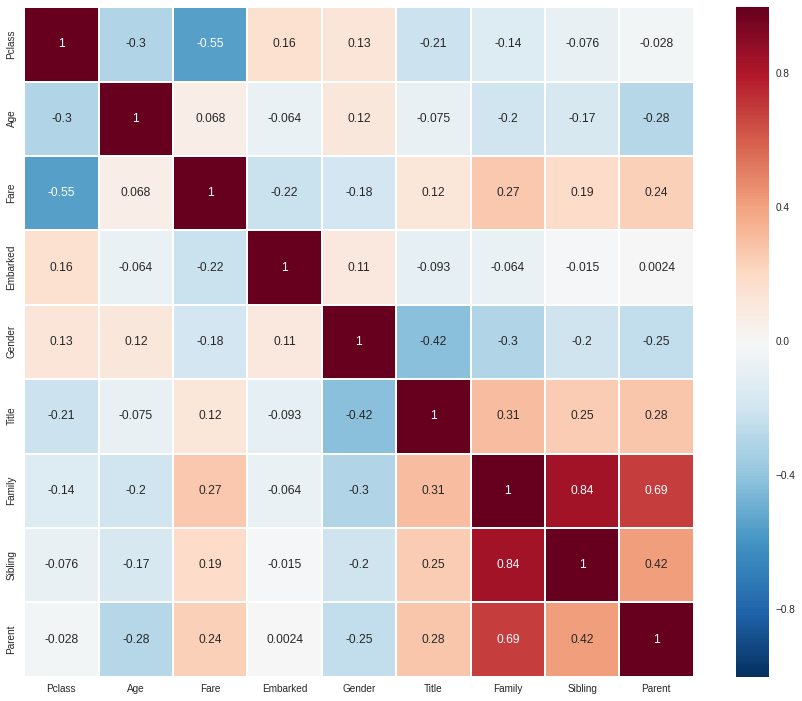

In [21]:
cor_mat = features.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax, annot=True);

## Survived correlation map

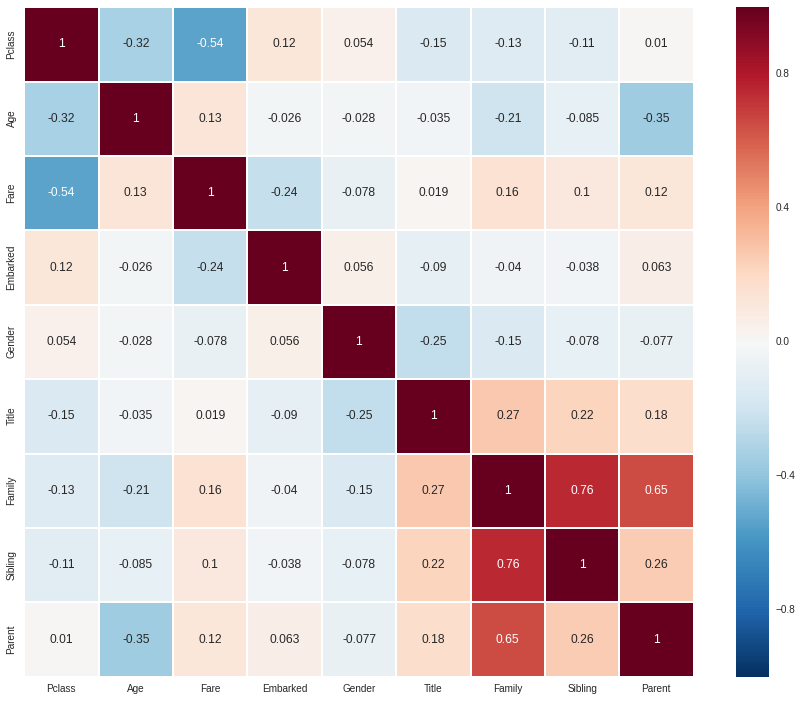

In [22]:
cor_mat = features[target==1].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax,annot=True);

## Death correlation map

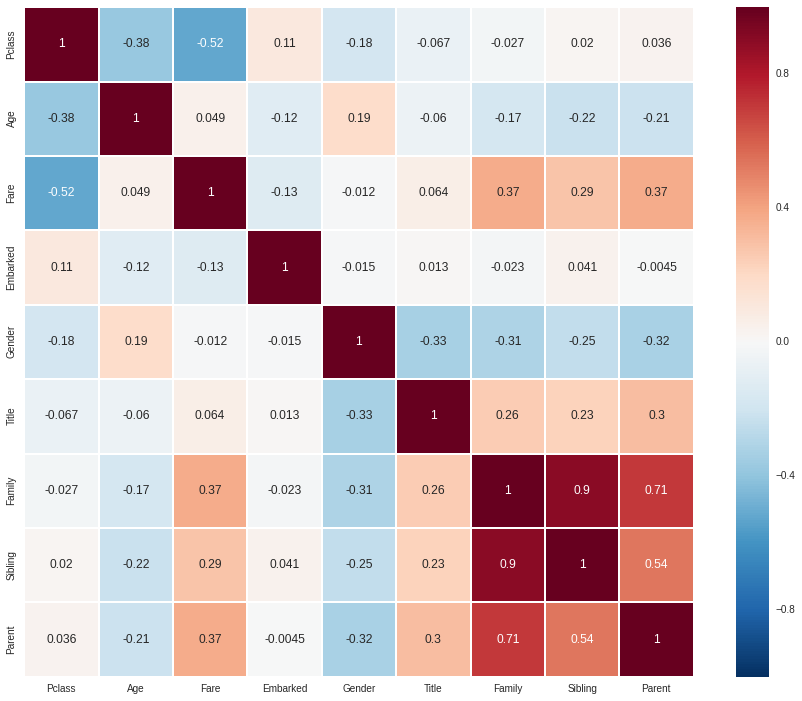

In [23]:
cor_mat = features[target==0].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax,annot=True);

## test visualization

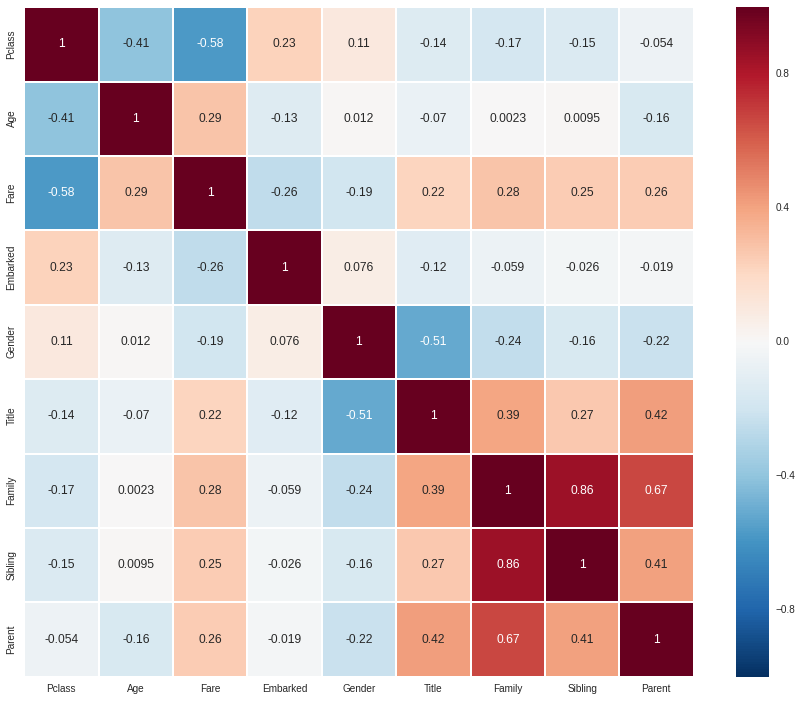

In [24]:
cor_mat = test_features.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax,annot=True);

In [25]:
def pairplot_test(data, vars):
    sns.pairplot(data, vars=vars, plot_kws={'alpha': 0.5, 'marker': '*'})


In [26]:
def print_features_histograms_test(features):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(10,  20))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2 + 1, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='test', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

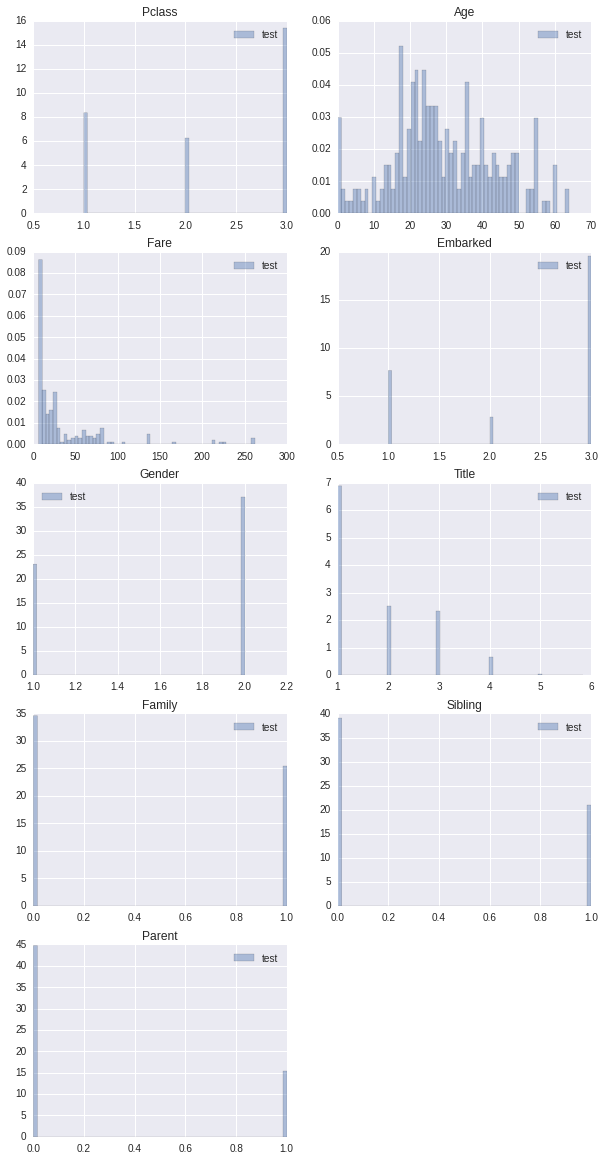

In [27]:
print_features_histograms_test(test_features)

In [28]:
def print_features_histograms_test_andtrain(features,target,test_features):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(10,  20))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2 + 1, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='death', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='alive', **hist_params)        
        ax.hist(test_features[feature].values, range=(min_value, max_value), 
                 label='test', **hist_params)

        ax.legend(loc='best')

        ax.set_title(feature)

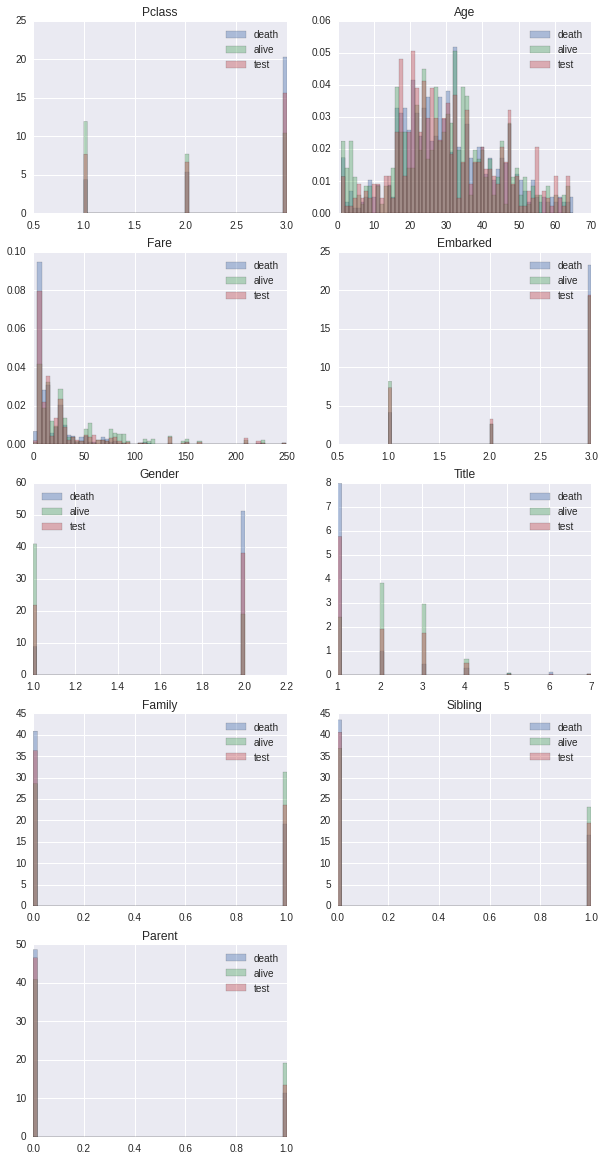

In [29]:
print_features_histograms_test_andtrain(features,target,test_features)

## Check whether the dataset is balanced

It is tricky to train model using misbalanced data. 

In [30]:
alive_nb = features[target == 1].count()[0]
death_nb = features[target == 0].count()[0]
print("alive_nb %d") % alive_nb
print("death_nb %d") % death_nb
ratio_death_to_alive = float(death_nb)/alive_nb
ratio_death_to_alive = np.round(ratio_death_to_alive, 3)
print ("ratio ghost to good %f") % ratio_death_to_alive

alive_nb 342
death_nb 549
ratio ghost to good 1.605000


# Train the basic version of Gradient Boosted Classifier

In [52]:
trainX, testX, trainY, testY = train_test_split(features, target,train_size=0.8 )
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, verbose = 3 )
gb.fit(trainX,trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2693           0.0837            3.58s
         2           1.1884           0.0610            2.59s
         3           1.1502           0.0539            1.96s
         4           1.0996           0.0400            1.63s
         5           1.0673           0.0220            1.45s
         6           1.0352           0.0298            1.36s
         7           1.0012           0.0221            1.26s
         8           0.9833           0.0210            1.19s
         9           0.9750           0.0166            1.13s
        10           0.9438           0.0093            1.08s
        11           0.9503           0.0156            1.04s
        12           0.9183           0.0099            1.02s
        13           0.9342           0.0117            1.04s
        14           0.8757           0.0025            1.06s
        15           0.9042           0.0061            1.05s
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [53]:
print "ROC AUC score of simple BDT"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])


ROC AUC score of simple BDT


0.82752153375937776

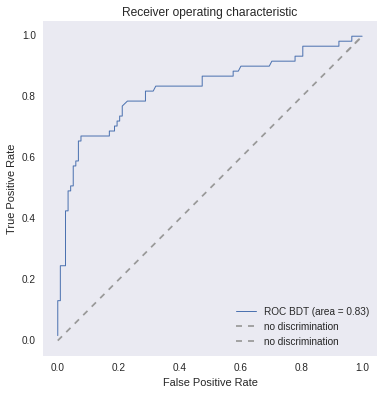

In [54]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [56]:
target_names = ['death', "alive"]
print("classification raport test")
print(classification_report(testY, gb.predict(testX), target_names=target_names))


classification raport test
             precision    recall  f1-score   support

      death       0.83      0.83      0.83       118
      alive       0.67      0.67      0.67        61

avg / total       0.78      0.78      0.78       179



In [57]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[98 20]
 [20 41]]


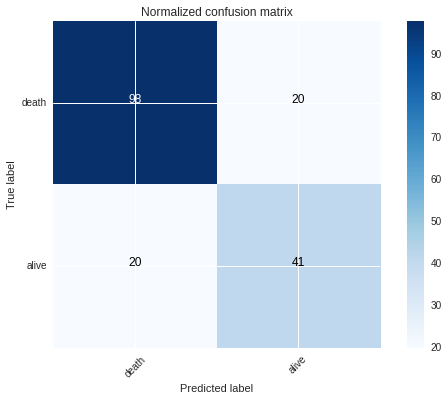

In [58]:
cnf_matrix = confusion_matrix(testY ,gb.predict(testX));
target_names = ["death","alive"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


## The most important metrics accurency
This is a pretty bad results about 182 possition :( 

In [59]:
accuracy_score(testY ,gb.predict(testX))

0.77653631284916202

In [60]:
accuracy_score(trainY ,gb.predict(trainX))

0.901685393258427

## Plot learning rate

In [61]:
predictions = gb.staged_predict(testX)
tree_scores = [] 
for predicted in predictions:
    score =  accuracy_score(testY, predicted)
    tree_scores.append(score)

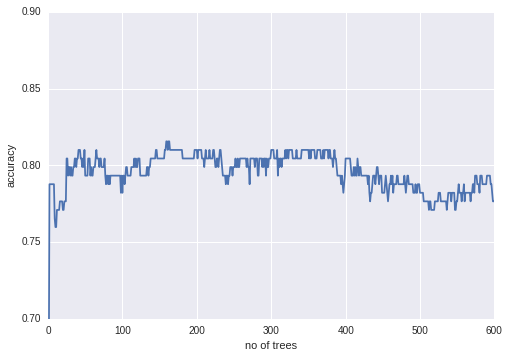

In [62]:
x = np.array([x  for x in range(600)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.7, 0.9)
plt.xlabel('no of trees')
plt.ylabel('accuracy')
plt.show()

In [63]:
def print_feature_importance(model, features):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    features_names =  list(features.columns.values)

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(features.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, features_names[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(features.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(features.shape[1]), features_names, rotation=70)
    plt.xlim([-1, features.shape[1]])
    plt.show()

Feature ranking:
1. feature Pclass (0.428474)
2. feature Age (0.291669)
3. feature Fare (0.069736)
4. feature Embarked (0.059587)
5. feature Gender (0.049572)
6. feature Title (0.030937)
7. feature Family (0.029796)
8. feature Sibling (0.027270)
9. feature Parent (0.012960)


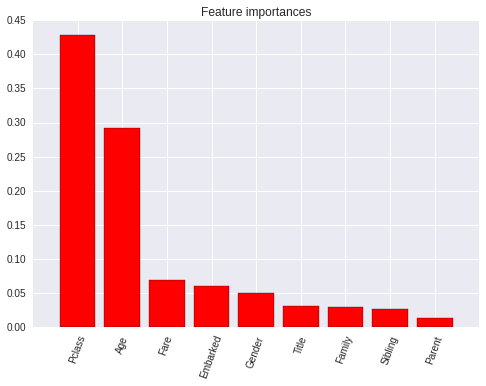

In [64]:
print_feature_importance(gb, features)

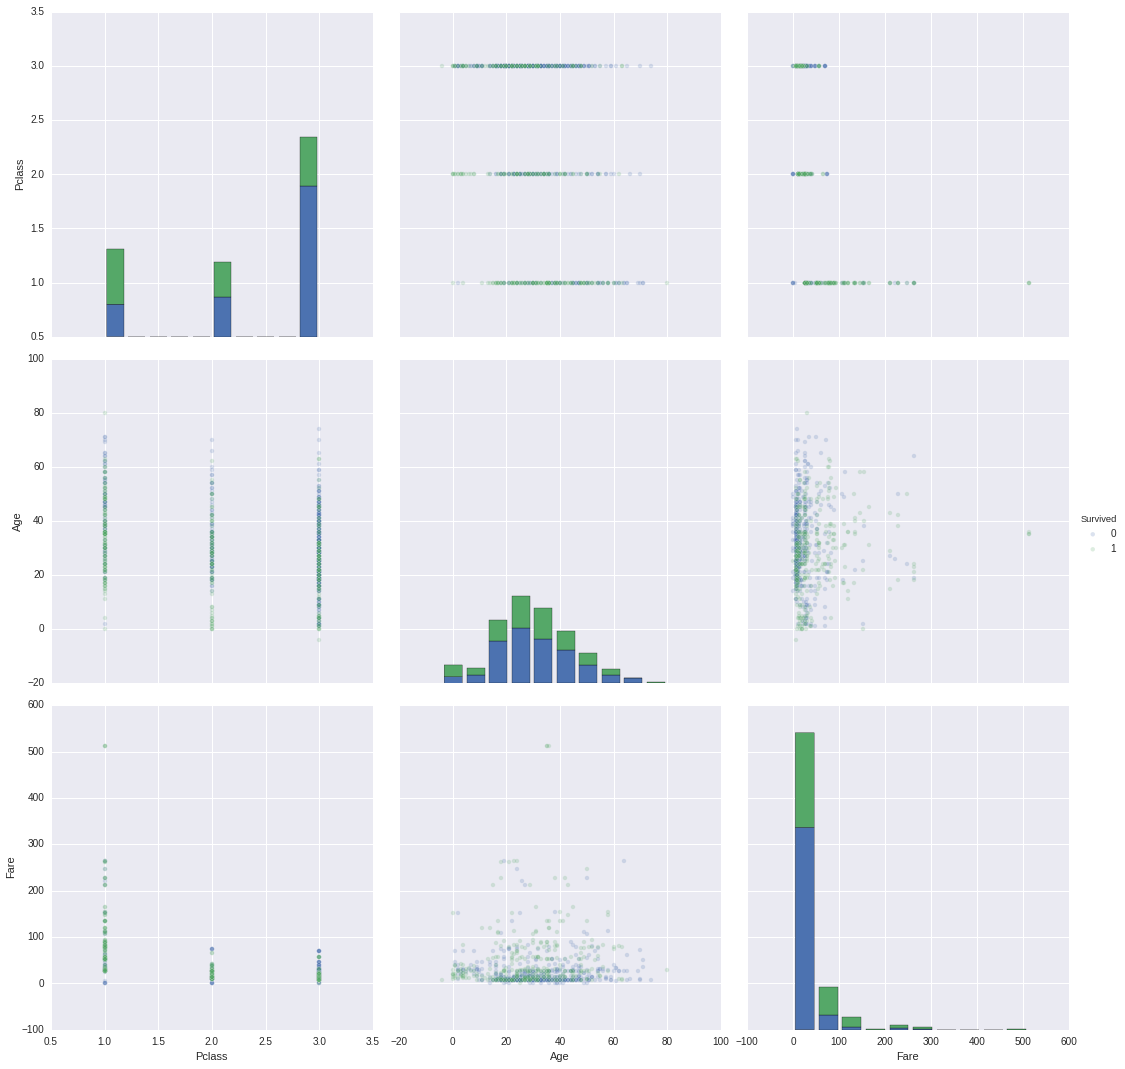

In [87]:
pairplot(train_df,vars=["Pclass","Age","Fare"] )

# Try to tune model hyperparameters to beat this reault

In [90]:
gb_grid_params = {'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [ 4, 6, 8 ],
              'min_samples_leaf': [20, 50,100,150],
               'min_samples_split':[50,100,200,500,800] 
                  
              }
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators = 600,subsample=0.8, random_state=13)


clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=6,
                               scoring='accuracy',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(features,target)

{'min_samples_split': [50, 100, 200, 500, 800], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]}
Fitting 6 folds for each of 180 candidates, totalling 1080 fits
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_sam

[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    2.6s


[CV]  min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.837838 -   0.8s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.844595 -   3.3s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.785235 -   0.9s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.817568 -   4.7s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.831081 -   5.1s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=4, min_sam

[Parallel(n_jobs=10)]: Done  32 jobs       | elapsed:   15.4s


[CV]  min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.785235 -   6.1s
[CV] min_samples_split=800, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.845638 -   6.2s
[CV] min_samples_split=800, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV]  min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.837838 -   1.2s
[CV]  min_samples_split=800, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.617450 -   0.9s
[CV] min_samples_split=800, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=100 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.837838 -   3.2s
[CV]  min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.844595 -   1.3s
[CV]  min_samples_split=200, learning_ra

[Parallel(n_jobs=10)]: Done 128 jobs       | elapsed:   36.5s


[CV]  min_samples_split=100, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.838926 -   4.4s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.837838 -   3.2s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.810811 -   4.2s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.832215 -   5.9s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.805369 -   7.3s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=6, min_s

[Parallel(n_jobs=10)]: Done 288 jobs       | elapsed:  1.6min


[CV]  min_samples_split=800, learning_rate=0.1, max_depth=8, min_samples_leaf=50, score=0.617450 -   1.2s
[CV] min_samples_split=800, learning_rate=0.1, max_depth=8, min_samples_leaf=50 
[CV]  min_samples_split=500, learning_rate=0.1, max_depth=8, min_samples_leaf=50, score=0.837838 -   1.8s
[CV] min_samples_split=800, learning_rate=0.1, max_depth=8, min_samples_leaf=50 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=8, min_samples_leaf=50, score=0.831081 -   3.2s
[CV] min_samples_split=50, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=500, learning_rate=0.1, max_depth=8, min_samples_leaf=50, score=0.844595 -   2.0s
[CV] min_samples_split=50, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=8, min_samples_leaf=50, score=0.865772 -   4.0s
[CV] min_samples_split=50, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=800, learning_rate=0.1, max_depth=8, min_

[Parallel(n_jobs=10)]: Done 512 jobs       | elapsed:  2.6min


[CV]  min_samples_split=50, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.812081 -   4.4s
[CV] min_samples_split=100, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=800, learning_rate=0.2, max_depth=6, min_samples_leaf=20, score=0.614865 -   5.2s
[CV] min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.838926 -   2.3s
[CV] min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=50, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.844595 -   8.0s
[CV] min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=50, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.797297 -  10.3s
[CV] min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=100, learning_rate=0.2, max_depth=6, min_sam

[Parallel(n_jobs=10)]: Done 800 jobs       | elapsed:  3.9min


[CV] min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.614865 -   0.8s
[CV] min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150, score=0.770270 -   0.7s
[CV] min_samples_split=100, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.617450 -   2.2s
[CV] min_samples_split=100, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=200, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.859060 -   6.3s
[CV] min_samples_split=100, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.614865 -   2.2s
[CV] min_samples_split=100, learning_rate=0.3, max_depth=4

[Parallel(n_jobs=10)]: Done 1080 out of 1080 | elapsed:  5.3min finished


GridSearchCV(cv=6, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'min_samples_split': [50, 100, 200, 500, 800], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=3)

In [91]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'min_samples_split': 200, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}
Grid scores on development set:
0.817 (+/-0.053) for {'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.822 (+/-0.043) for {'min_samples_split': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.834 (+/-0.063) for {'min_samples_split': 200, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.820 (+/-0.060) for {'min_samples_split': 500, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.616 (+/-0.003) for {'min_samples_split': 800, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.831 (+/-0.043) for {'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}
0.831 (+/-0.043) for {'min_samples_split': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}
0.844 (+/-0.050) for {'min_samples_split': 200, 'learning_rate': 

In [45]:
# Train the best model

In [92]:
best_params={'min_samples_split': 200, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}

gb = GradientBoostingClassifier( n_estimators=600, subsample=0.8, random_state=13,
                               verbose = 3,
                               **best_params)
gb.fit(trainX,trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2676           0.0854            1.55s
         2           1.1849           0.0636            2.71s
         3           1.1457           0.0527            2.08s
         4           1.0931           0.0400            2.12s
         5           1.0554           0.0292            2.15s
         6           1.0241           0.0299            2.38s
         7           0.9900           0.0230            2.46s
         8           0.9714           0.0211            2.89s
         9           0.9587           0.0225            2.67s
        10           0.9240           0.0117            2.48s
        11           0.9305           0.0150            2.32s
        12           0.8931           0.0092            2.19s
        13           0.9045           0.0143            2.12s
        14           0.8518           0.0046            2.04s
        15           0.8699           0.0062            1.96s
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [94]:
accuracy_score(testY ,gb.predict(testX))

0.79329608938547491

Confusion matrix, without normalization
[[101  17]
 [ 20  41]]


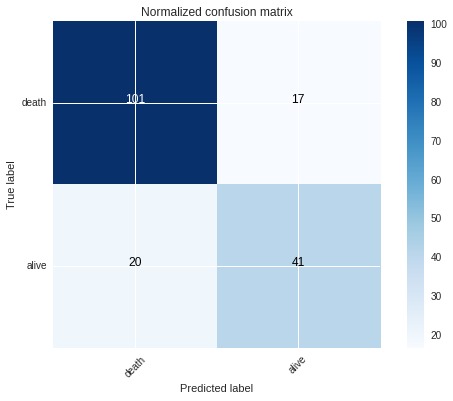

In [95]:
cnf_matrix = confusion_matrix(testY ,gb.predict(testX));
target_names = ["death","alive"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


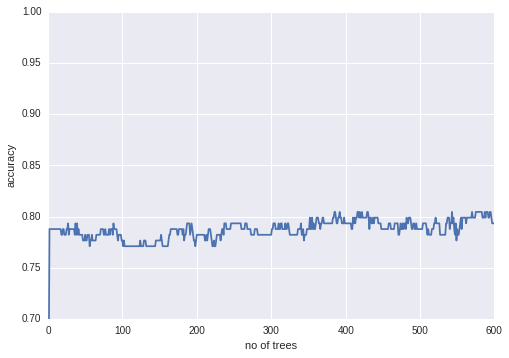

In [96]:
predictions = gb.staged_predict(testX)
tree_scores = [] 
for predicted in predictions:
    score =  accuracy_score(testY, predicted)
    tree_scores.append(score)
x = np.array([x  for x in range(600)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.7, 1)
plt.xlabel('no of trees')
plt.ylabel('accuracy')
plt.show()

[ 0.81111111  0.84444444  0.76404494  0.87640449  0.86516854  0.80898876
  0.87640449  0.82022472  0.80898876  0.82954545]
0.83053257292


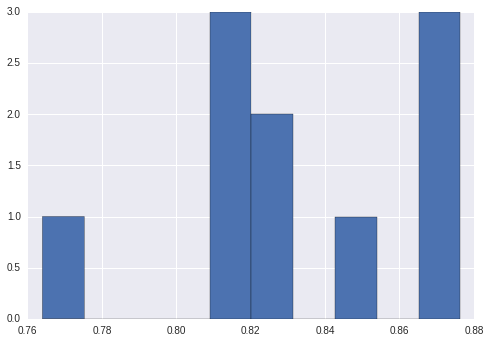

In [99]:
gb = GradientBoostingClassifier(n_estimators=600, subsample=0.8, random_state=13,
                               **best_params)

scores = cross_validation.cross_val_score(gb, features, target, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())
plt.hist(scores, bins=10);


## Add ratios of the features

In [110]:
def add_ratios(df):
    df["age/pclass"]=df.Age/(df.Pclass)
    df["fare/pclass"]=df.Fare/(df.Pclass)
    df["age/title"]=df.Age/(df.Title)
    df["fare/title"]=df.Fare/(df.Title)

In [111]:
add_ratios(features)
features.head()

,Pclass,Age,Fare,Embarked,Gender,Title,Family,Sibling,Parent,age/pclass,fare/pclass,age/title,fare/title
0,3,22,7.2500,3,2,1,1,1,0,7.333333,2.416667,22.000000,7.2500
1,1,38,71.2833,1,1,3,1,1,0,38.000000,71.283300,12.666667,23.7611
2,3,26,7.9250,3,1,2,0,0,0,8.666667,2.641667,13.000000,3.9625
3,1,35,53.1000,3,1,3,1,1,0,35.000000,53.100000,11.666667,17.7000
4,3,35,8.0500,3,2,1,0,0,0,11.666667,2.683333,35.000000,8.0500


In [113]:
add_ratios(test_features)
test_features.head()

,Pclass,Age,Fare,Embarked,Gender,Title,Family,Sibling,Parent,age/pclass,fare/pclass,age/title,fare/title
0,3,34,7.8292,2,2,1,0,0,0,11.333333,2.609733,34.000000,7.829200
1,3,47,7.0000,3,1,3,1,1,0,15.666667,2.333333,15.666667,2.333333
2,2,62,9.6875,2,2,1,0,0,0,31.000000,4.843750,62.000000,9.687500
3,3,27,8.6625,3,2,1,0,0,0,9.000000,2.887500,27.000000,8.662500
4,3,22,12.2875,3,1,3,1,1,1,7.333333,4.095833,7.333333,4.095833


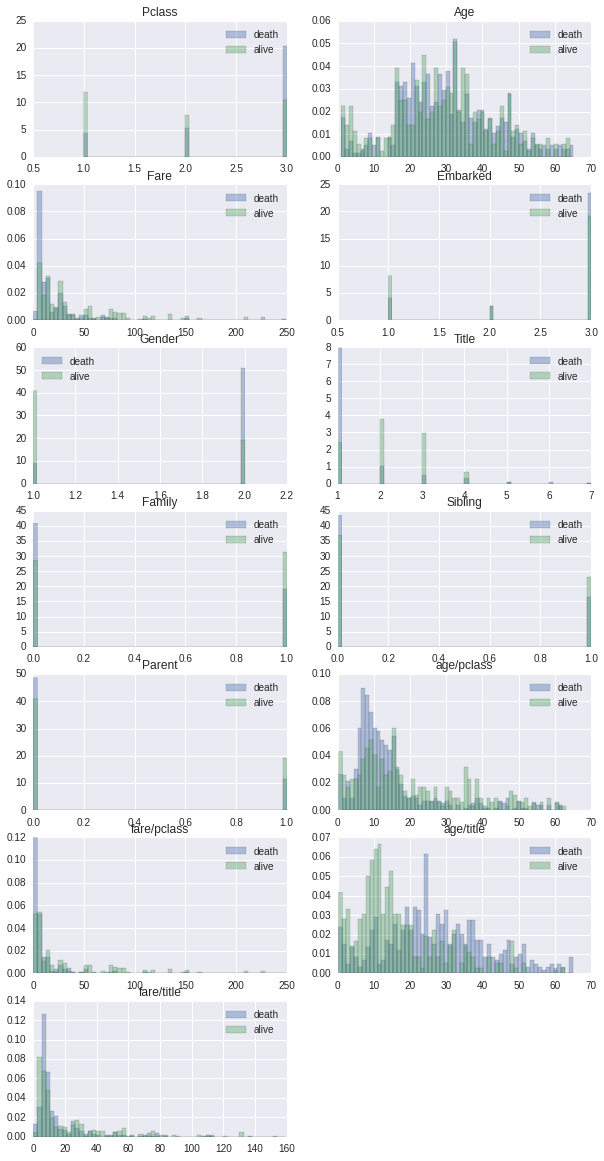

In [112]:
print_features_histograms(features,target)

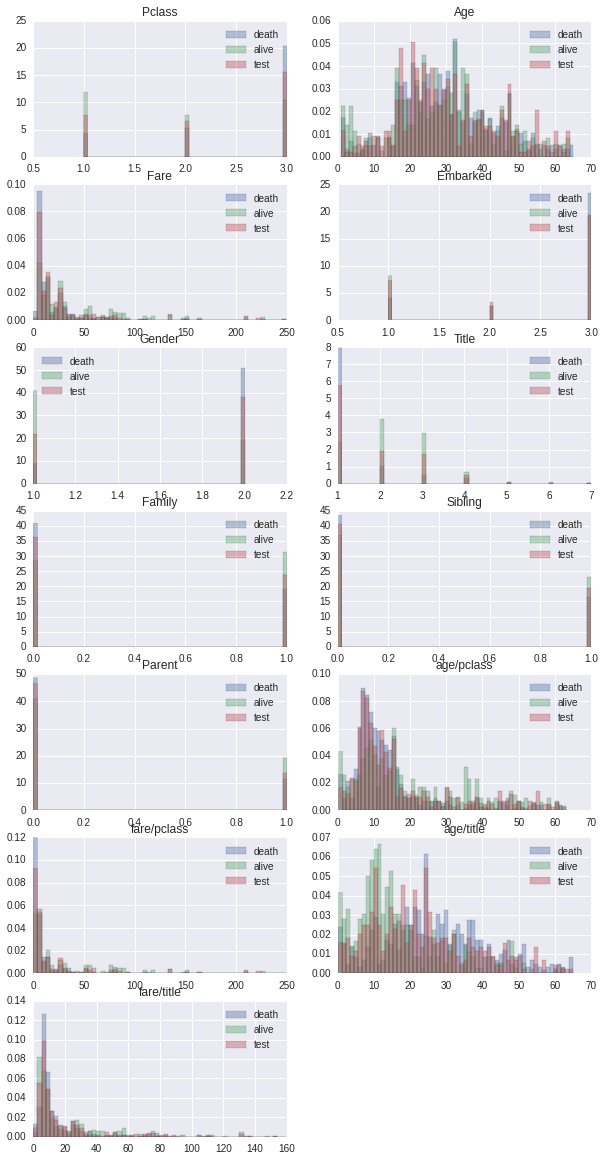

In [114]:
print_features_histograms_test_andtrain(features,target,test_features)

In [115]:
trainX, testX, trainY, testY = train_test_split(features, target,train_size=0.8 )
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, verbose = 3 )
gb.fit(trainX,trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2645           0.0809            3.22s
         2           1.1939           0.0545            2.29s
         3           1.1709           0.0553            1.98s
         4           1.1113           0.0331            2.03s
         5           1.0702           0.0353            1.96s
         6           1.0354           0.0205            1.87s
         7           1.0095           0.0197            3.34s
         8           1.0044           0.0211            3.12s
         9           0.9750           0.0168            2.90s
        10           0.9564           0.0111            2.79s
        11           0.9700           0.0164            2.69s
        12           0.9373           0.0101            3.21s
        13           0.9123           0.0077            3.07s
        14           0.9159           0.0044            2.98s
        15           0.8902           0.0029            3.31s
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [116]:
print "ROC AUC score of simple BDT"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])


ROC AUC score of simple BDT


0.84868597479216934

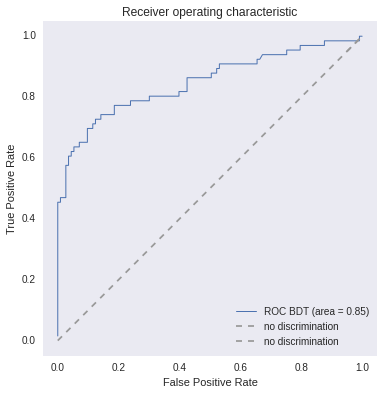

In [117]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [118]:
target_names = ['death', "alive"]
print("classification raport test")
print(classification_report(testY, gb.predict(testX), target_names=target_names))


classification raport test
             precision    recall  f1-score   support

      death       0.82      0.93      0.87       113
      alive       0.84      0.65      0.74        66

avg / total       0.83      0.83      0.82       179



In [119]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[105   8]
 [ 23  43]]


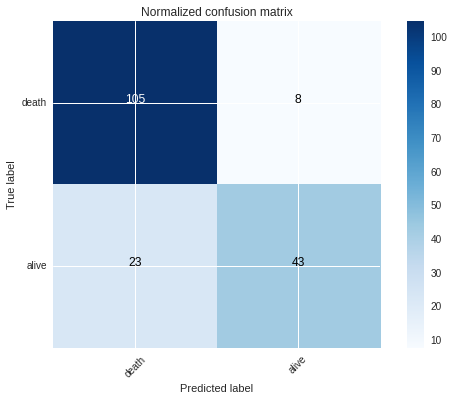

In [120]:
cnf_matrix = confusion_matrix(testY ,gb.predict(testX));
target_names = ["death","alive"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


## The most important metrics accurency
This is a pretty bad results about 182 possition :( 

In [121]:
accuracy_score(testY ,gb.predict(testX))

0.82681564245810057

In [122]:
accuracy_score(trainY ,gb.predict(trainX))

0.9030898876404494

In [123]:
gb_grid_params = {'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [ 4, 6, 8 ],
              'min_samples_leaf': [20, 50,100,150],
               'min_samples_split':[50,100,200,500,800] 
                  
              }
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators = 600,subsample=0.8, random_state=13)


clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=6,
                               scoring='accuracy',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(features,target)

{'min_samples_split': [50, 100, 200, 500, 800], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]}
Fitting 6 folds for each of 180 candidates, totalling 1080 fits
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV] min_samples_split=50, learning_rate=0.1, max_depth=4, min_sam

[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    8.8s


[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.831081 -   1.4s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.844595 -   9.2s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.832215 -   3.7s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.744966 -   9.7s
[CV] min_samples_split=800, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.824324 -   1.0s
[CV] min_samples_split=800, learning_rate=0.1, max_depth=4, min_samples_leaf=20 
[CV]  min_samples_split=800, learning_rate=0.1, max_depth=4, min_s

[Parallel(n_jobs=10)]: Done  32 jobs       | elapsed:   15.8s


[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.798658 -   1.5s
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.785235 -   1.5s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV] min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.845638 -   1.4s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV]  min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.785235 -   0.5s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.851351 -   5.5s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=4, min_samples_leaf=50 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=4, min_s

[Parallel(n_jobs=10)]: Done 128 jobs       | elapsed:   39.3s


[CV]  min_samples_split=50, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.831081 -   7.4s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.851351 -   5.1s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.812081 -   2.4s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.818792 -   5.6s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=100, learning_rate=0.1, max_depth=6, min_samples_leaf=20, score=0.798658 -   6.8s
[CV] min_samples_split=500, learning_rate=0.1, max_depth=6, min_samples_leaf=20 
[CV]  min_samples_split=200, learning_rate=0.1, max_depth=6, min_s

[Parallel(n_jobs=10)]: Done 288 jobs       | elapsed:  1.7min


[CV]  min_samples_split=100, learning_rate=0.1, max_depth=8, min_samples_leaf=100, score=0.818792 -   0.9s
[CV] min_samples_split=100, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=8, min_samples_leaf=100, score=0.798658 -   2.1s
[CV] min_samples_split=100, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=8, min_samples_leaf=100, score=0.852349 -   2.2s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=8, min_samples_leaf=100, score=0.844595 -   2.0s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=8, min_samples_leaf=100, score=0.844595 -   2.5s
[CV] min_samples_split=200, learning_rate=0.1, max_depth=8, min_samples_leaf=100 
[CV]  min_samples_split=50, learning_rate=0.1, max_depth=8,

[Parallel(n_jobs=10)]: Done 512 jobs       | elapsed:  2.5min


[CV]  min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.771812 -   1.0s
[CV] min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=100, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.812081 -   2.8s
[CV] min_samples_split=500, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=50, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.837838 -   3.2s
[CV] min_samples_split=500, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=100, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.837838 -   2.7s
[CV] min_samples_split=500, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=200, learning_rate=0.2, max_depth=6, min_samples_leaf=50, score=0.837838 -   0.9s
[CV] min_samples_split=500, learning_rate=0.2, max_depth=6, min_samples_leaf=50 
[CV]  min_samples_split=200, learning_rate=0.2, max_depth=6, min_s

[Parallel(n_jobs=10)]: Done 800 jobs       | elapsed:  3.5min


[CV]  min_samples_split=800, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.617450 -   0.5s
[CV] min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=200, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.831081 -   2.6s
[CV] min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=500, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.858108 -   1.5s
[CV] min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.617450 -   0.7s
[CV] min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.614865 -   0.6s
[CV] min_samples_split=50, learning_rate=0.3, max_depth=4, min_samples_leaf=150 
[CV]  min_samples_split=500, learning_rate=0.3, max_depth=4,

[Parallel(n_jobs=10)]: Done 1062 out of 1080 | elapsed:  4.9min remaining:    5.0s


[CV]  min_samples_split=200, learning_rate=0.3, max_depth=8, min_samples_leaf=150, score=0.818792 -   5.3s
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=8, min_samples_leaf=150, score=0.617450 -   0.4s
[CV] min_samples_split=800, learning_rate=0.3, max_depth=8, min_samples_leaf=150 
[CV] min_samples_split=800, learning_rate=0.3, max_depth=8, min_samples_leaf=150 
[CV]  min_samples_split=200, learning_rate=0.3, max_depth=8, min_samples_leaf=150, score=0.837838 -   3.4s
[CV]  min_samples_split=500, learning_rate=0.3, max_depth=8, min_samples_leaf=150, score=0.791946 -   3.7s
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=8, min_samples_leaf=150, score=0.614865 -   1.8s
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=8, min_samples_leaf=150, score=0.614865 -   2.0s
[CV]  min_samples_split=800, learning_rate=0.3, max_depth=8, min_samples_leaf=150, score=0.614865 -   1.7s
[CV]  min_samples_split=500, learning_rate=0.3, max_depth=8, min_samples_leaf=150, scor

[Parallel(n_jobs=10)]: Done 1080 out of 1080 | elapsed:  5.0min finished


GridSearchCV(cv=6, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'min_samples_split': [50, 100, 200, 500, 800], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=3)

In [124]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 100}
Grid scores on development set:
0.810 (+/-0.078) for {'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.816 (+/-0.067) for {'min_samples_split': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.825 (+/-0.075) for {'min_samples_split': 200, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.817 (+/-0.053) for {'min_samples_split': 500, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.616 (+/-0.003) for {'min_samples_split': 800, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20}
0.829 (+/-0.053) for {'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}
0.829 (+/-0.053) for {'min_samples_split': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}
0.834 (+/-0.063) for {'min_samples_split': 200, 'learning_rate': 

In [128]:
best_params ={'min_samples_split': 50, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 100}
gb = GradientBoostingClassifier(n_estimators=600, subsample=0.8, random_state=13,
                                verbose = 3,
                               **best_params)
gb.fit(trainX,trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2645           0.0809            4.72s
         2           1.1939           0.0545            2.83s
         3           1.1709           0.0553            2.22s
         4           1.1113           0.0331            1.86s
         5           1.0702           0.0353            1.64s
         6           1.0354           0.0205            1.49s
         7           1.0095           0.0197            1.38s
         8           1.0044           0.0211            1.31s
         9           0.9750           0.0168            1.24s
        10           0.9564           0.0111            1.20s
        11           0.9700           0.0164            1.16s
        12           0.9373           0.0101            1.12s
        13           0.9123           0.0077            1.09s
        14           0.9159           0.0044            1.08s
        15           0.8902           0.0029            1.05s
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [129]:
accuracy_score(testY ,gb.predict(testX))

0.82681564245810057

Feature ranking:
1. feature Pclass (0.173743)
2. feature Age (0.158947)
3. feature Fare (0.149734)
4. feature Embarked (0.140295)
5. feature Gender (0.137845)
6. feature Title (0.111052)
7. feature Family (0.034548)
8. feature Sibling (0.026068)
9. feature Parent (0.021594)
10. feature age/pclass (0.018215)
11. feature fare/pclass (0.015515)
12. feature age/title (0.009312)
13. feature fare/title (0.003133)


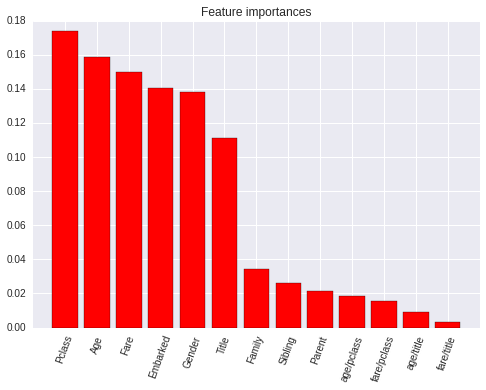

In [130]:
print_feature_importance(gb,features)

[ 0.8         0.82222222  0.76404494  0.84269663  0.8988764   0.85393258
  0.87640449  0.83146067  0.83146067  0.88636364]
0.840746226308


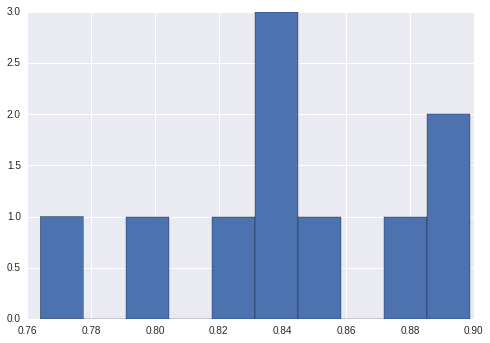

In [127]:
gb = GradientBoostingClassifier(n_estimators=600, subsample=0.8, random_state=13,
                               **best_params)

scores = cross_validation.cross_val_score(gb, features, target, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())
plt.hist(scores, bins=10);


# Make submission

In [131]:
output = gb.predict(test_features).astype(int)
predictions_file = open("BDT_ratios.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()

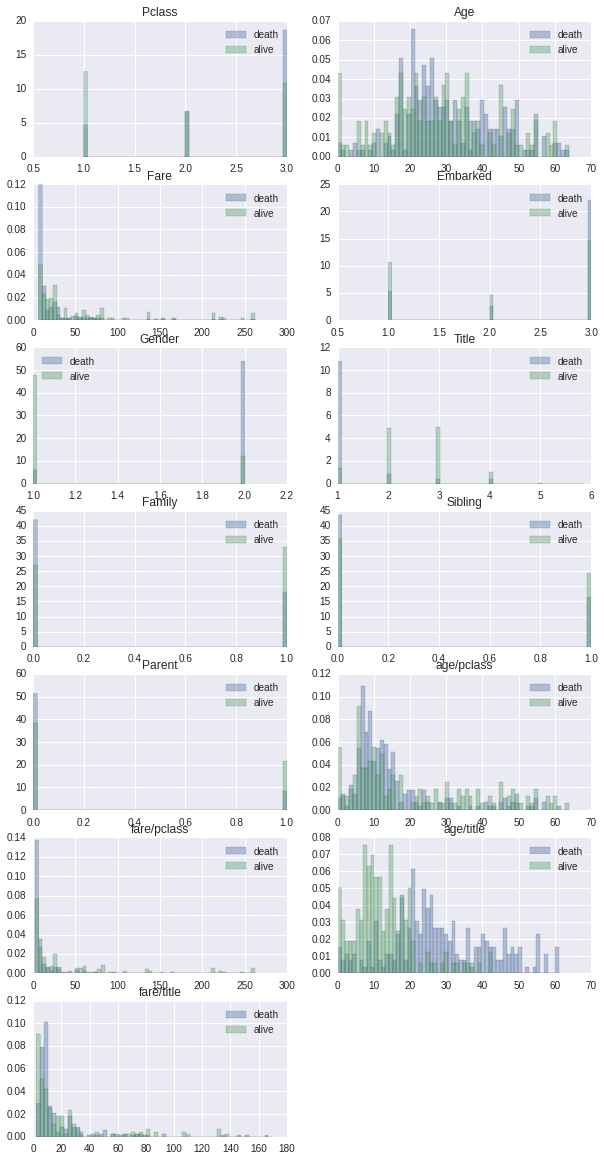

In [132]:
print_features_histograms(test_features,output)